# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment


# Load Reacher env with 20 agents
# env = UnityEnvironment(file_name='Reacher')
env = UnityEnvironment(file_name='/home/arasdar/unity-envs/Reacher_Linux_NoVis_MultiAgents/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Instantiate DAQL Agent

In [4]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
GAMMA = 0.99            # discount factor
LR = 1e-3        # learning rate of the critic
BATCH_SIZE = 1024         # minibatch size/ RAM size
BUFFER_SIZE = int(1e6)  # replay buffer size
random_seed = 7 # random seed for result reproducibility
h_size = 400 # hidden layer size

In [6]:
from agent import Agent

agent = Agent(s_size=state_size, a_size=action_size, h_size=400, random_seed=random_seed, gamma=GAMMA, 
              lr=LR, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, device=device)

### 4. Train the Agent with DAQL

In [7]:
# # env_info.agents, 
# env_info.local_done, 
# env_info.max_reached
# env_info.memories
# env_info.visual_observations

In [8]:
from collections import deque
import numpy as np
import time
import torch

In [9]:
# # n [1]: import torch

# # In [2]: 
print(torch.cuda.current_device())
# # Out[2]: 0

# In [3]: 
print(torch.cuda.device(0))
# Out[3]: <torch.cuda.device at 0x7efce0b03be0>

# In [4]: 
print(torch.cuda.device_count())
# Out[4]: 1

# In [5]: 
print(torch.cuda.get_device_name(0))
# Out[5]: 'GeForce GTX 950M'

# In [6]: 
print(torch.cuda.is_available())
# Out[6]: True

0
1
Quadro P5000
True


In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Quadro P5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
n_episodes=1000
n_steps=1000
n_learn=20 # numbe of agents: once per agent
learn_every=20 # learn every 20 steps/timesteps
R_goal=30 # TOCHECK
Rs_deque = deque(maxlen=100)
list_episodes = []

In [12]:
for i_episode in range(n_episodes):
    
    # Reset Env and Agent
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment (env)    
    S = env_info.vector_observations                   # get the current states (S) (for all agents)

    Rs = np.zeros(num_agents)                            # initialize the total scores (Rs) (for all agents)
    list_steps = []

    for i_step in range(n_steps):
        
        A = agent.act(S) # A: actions [-1, +1], S: current states for all agents
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        env_info = env.step(A)[brain_name]            # send all actions (A) to the environment (env)
        S2 = env_info.vector_observations          # get next states (S) (for all agents)
        rewards = env_info.rewards                          # get rewards (for all agents)
        dones = env_info.local_done                         # see if episode is done/finished (terminal) for all agents
        
        if np.any(rewards) < 0 or np.any(rewards) > 1:
            print(rewards)
        
        # Hippocampus: episodic memory
        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        for s, a, r, s2, done in zip(S, A, rewards, S2, dones):
            # send an exprience (e) to the agent or collecting experiences (E)
            agent.memory.add(s, a, r, s2, done)

        Rs += rewards                           # update the total scores (for all agents)
        S = S2                                # roll over states (S) to next states (S2)

        if i_step%learn_every == 0:
            for _ in range(n_learn):
                gloss, dloss, reward, reward_in = agent.start_learn()
                list_steps.append([gloss, dloss, reward, reward_in])
                
        if np.any(dones): # exit loop if episode is done/finished for any of the agents among all of them
            break

    Rs_deque.append(np.mean(Rs))
    
    print('Episode:{}, Total Average Score:{:.2f}'.format(i_episode+1, np.mean(Rs_deque)),
          'gloss:{:.2f}'.format(np.mean(list_steps, axis=0)[0]), 
          'dloss:{:.2f}'.format(np.mean(list_steps, axis=0)[1]),
          'reward:{:.5f}'.format(np.mean(list_steps, axis=0)[2]), 
          'reward_in:{:.5f}'.format(np.mean(list_steps, axis=0)[3]))
    
    # Plotting
    list_episodes.append([np.mean(Rs_deque),
                          np.mean(list_steps, axis=0)[0], # gloss
                          np.mean(list_steps, axis=0)[1], # dloss
                          np.mean(list_steps, axis=0)[2], # reward
                          np.mean(list_steps, axis=0)[3]]) # reward_in

    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-reacher-multiple.pth')
        torch.save(agent.d.state_dict(), 'd-reacher-multiple.pth')
        break

Episode:1, Total Average Score:0.63 gloss:0.51 dloss:-0.02 reward:0.00042 reward_in:0.00003
Episode:2, Total Average Score:0.82 gloss:0.76 dloss:-0.02 reward:0.00071 reward_in:0.00011
Episode:3, Total Average Score:0.92 gloss:0.94 dloss:-0.02 reward:0.00086 reward_in:0.00012
Episode:4, Total Average Score:0.88 gloss:0.96 dloss:-0.02 reward:0.00088 reward_in:0.00010
Episode:5, Total Average Score:0.85 gloss:1.13 dloss:-0.02 reward:0.00088 reward_in:0.00009
Episode:6, Total Average Score:0.85 gloss:2.93 dloss:-0.03 reward:0.00084 reward_in:0.00013
Episode:7, Total Average Score:0.87 gloss:6.26 dloss:-0.05 reward:0.00086 reward_in:0.00013
Episode:8, Total Average Score:0.96 gloss:10.06 dloss:-0.09 reward:0.00092 reward_in:0.00013
Episode:9, Total Average Score:1.06 gloss:11.67 dloss:-0.13 reward:0.00102 reward_in:0.00015
Episode:10, Total Average Score:1.16 gloss:12.06 dloss:-0.17 reward:0.00112 reward_in:0.00012
Episode:11, Total Average Score:1.32 gloss:12.76 dloss:-0.20 reward:0.00125 

Episode:88, Total Average Score:18.72 gloss:32.90 dloss:-3.65 reward:0.02608 reward_in:0.00009
Episode:89, Total Average Score:18.79 gloss:32.41 dloss:-3.67 reward:0.02632 reward_in:0.00010
Episode:90, Total Average Score:18.88 gloss:32.38 dloss:-3.69 reward:0.02650 reward_in:0.00008
Episode:91, Total Average Score:18.95 gloss:31.79 dloss:-3.70 reward:0.02666 reward_in:0.00009
Episode:92, Total Average Score:19.05 gloss:31.60 dloss:-3.72 reward:0.02673 reward_in:0.00009
Episode:93, Total Average Score:19.12 gloss:31.40 dloss:-3.73 reward:0.02679 reward_in:0.00008
Episode:94, Total Average Score:19.22 gloss:30.84 dloss:-3.74 reward:0.02689 reward_in:0.00009
Episode:95, Total Average Score:19.34 gloss:30.94 dloss:-3.75 reward:0.02701 reward_in:0.00010
Episode:96, Total Average Score:19.43 gloss:31.01 dloss:-3.76 reward:0.02719 reward_in:0.00009
Episode:97, Total Average Score:19.51 gloss:30.83 dloss:-3.77 reward:0.02725 reward_in:0.00010
Episode:98, Total Average Score:19.62 gloss:30.55 

Episode:174, Total Average Score:29.60 gloss:23.83 dloss:-4.05 reward:0.03092 reward_in:0.00008
Episode:175, Total Average Score:29.65 gloss:23.62 dloss:-4.05 reward:0.03083 reward_in:0.00009
Episode:176, Total Average Score:29.64 gloss:23.48 dloss:-4.04 reward:0.03076 reward_in:0.00008
Episode:177, Total Average Score:29.64 gloss:23.46 dloss:-4.04 reward:0.03065 reward_in:0.00008
Episode:178, Total Average Score:29.66 gloss:23.64 dloss:-4.03 reward:0.03051 reward_in:0.00008
Episode:179, Total Average Score:29.70 gloss:24.03 dloss:-4.02 reward:0.03049 reward_in:0.00009
Episode:180, Total Average Score:29.78 gloss:24.22 dloss:-4.02 reward:0.03047 reward_in:0.00007
Episode:181, Total Average Score:29.86 gloss:24.12 dloss:-4.02 reward:0.03047 reward_in:0.00008
Episode:182, Total Average Score:29.91 gloss:24.10 dloss:-4.02 reward:0.03052 reward_in:0.00008
Episode:183, Total Average Score:29.97 gloss:23.67 dloss:-4.01 reward:0.03052 reward_in:0.00008
Episode:184, Total Average Score:30.02 g

### 5. Plot the result

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# # Plotting
# list_episodes.append([np.mean(Rs_deque),
#                       np.mean(list_steps, axis=0)[0], # gloss
#                       np.mean(list_steps, axis=0)[1], # dloss
#                       np.mean(list_steps, axis=0)[2], # reward
#                       np.mean(list_steps, axis=0)[3]]) # reward_in

In [23]:
np.array(list_episodes).shape

(184, 5)

In [24]:
np.array(list_episodes).T.shape

(5, 184)

In [25]:
np.array(list_episodes).T[0].shape

(184,)

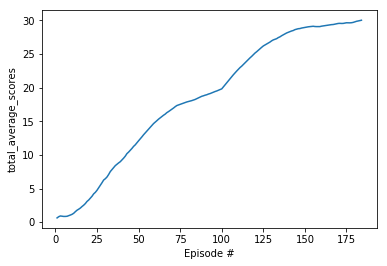

In [26]:
arr = np.array(list_episodes).T[0]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

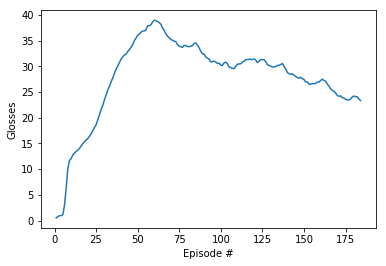

In [27]:
arr = np.array(list_episodes).T[1]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Glosses')
plt.xlabel('Episode #')
plt.show()

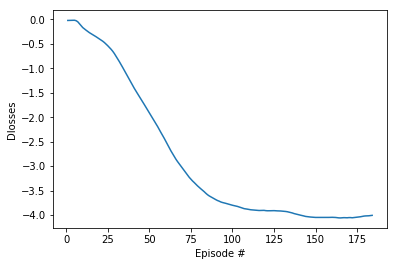

In [28]:
arr = np.array(list_episodes).T[2]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Dlosses')
plt.xlabel('Episode #')
plt.show()

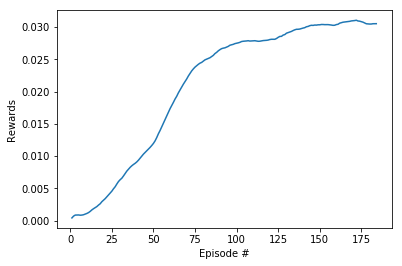

In [29]:
arr = np.array(list_episodes).T[3]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Rewards')
plt.xlabel('Episode #')
plt.show()

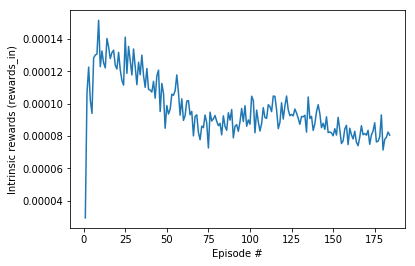

In [30]:
arr = np.array(list_episodes).T[4]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(arr)+1), arr)
plt.ylabel('Intrinsic rewards (rewards_in)')
plt.xlabel('Episode #')
plt.show()

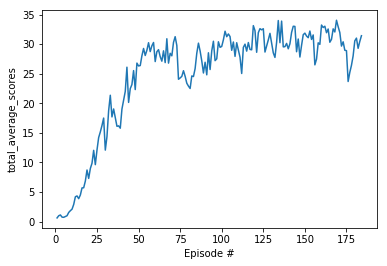

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

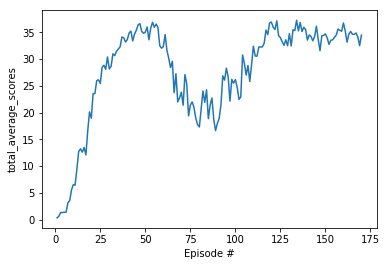

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

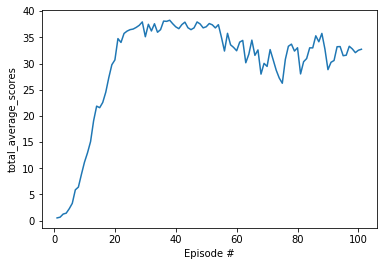

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [12]:
glosses = [each[0] for each in losses__]

In [13]:
dlosses = [-each[1] for each in losses__]

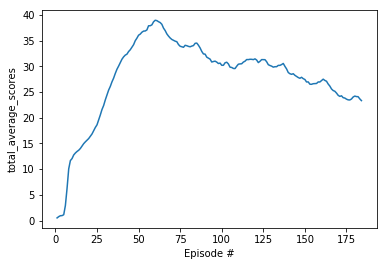

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

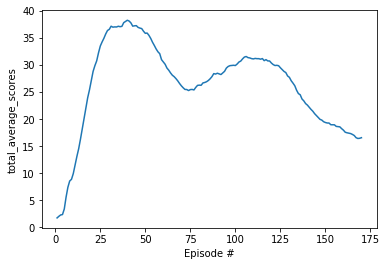

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

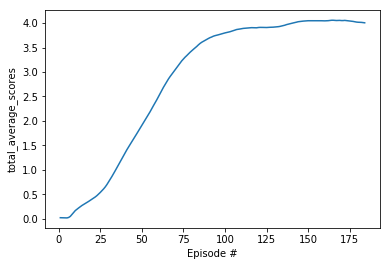

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

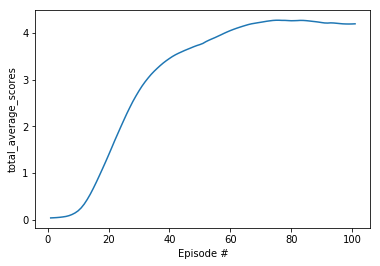

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

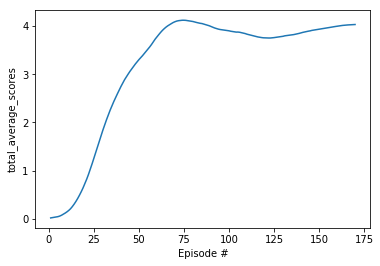

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

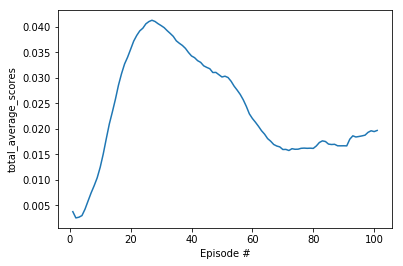

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

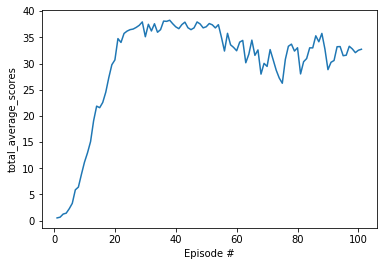

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

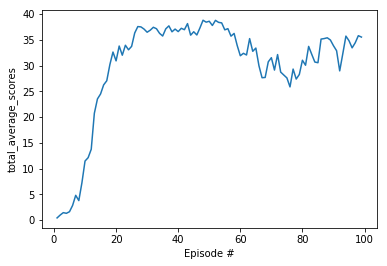

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [10]:
glosses = [-each[0] for each in losses__]

In [11]:
dlosses = [each[1] for each in losses__]

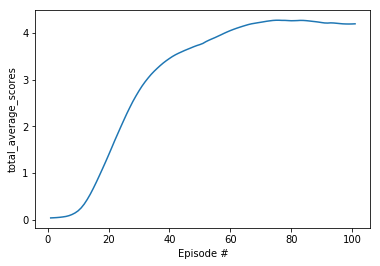

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

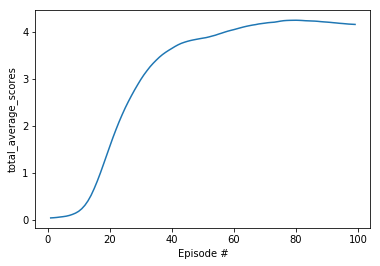

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

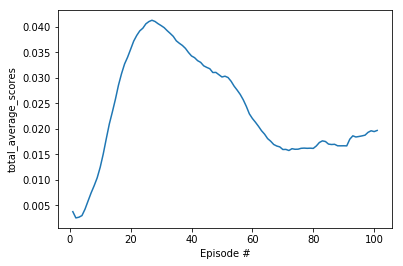

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

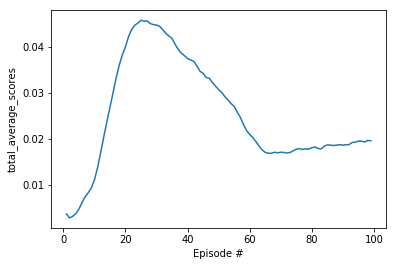

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

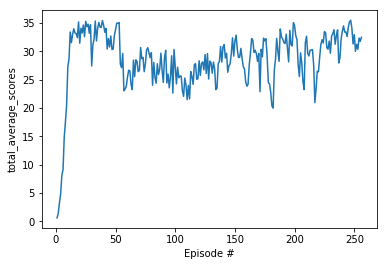

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [28]:
# len(losses__), [each[0] for each in losses__], losses__[0][0]

In [36]:
glosses = [-each[0] for each in losses__]

In [37]:
dlosses = [each[1] for each in losses__]

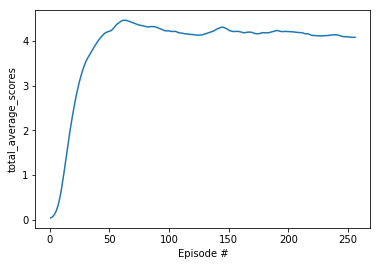

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

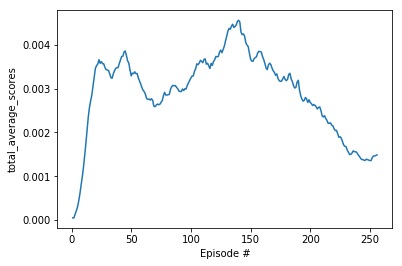

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

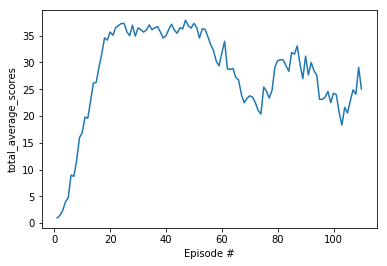

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

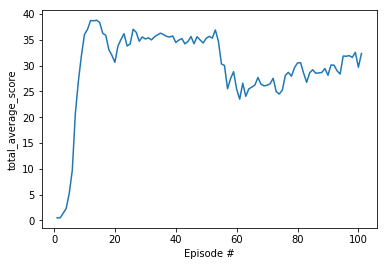

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

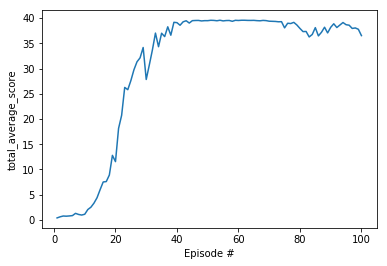

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

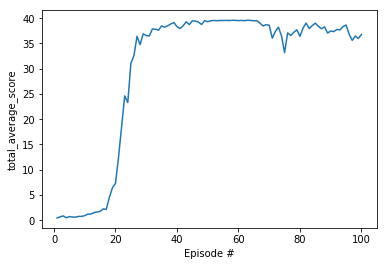

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

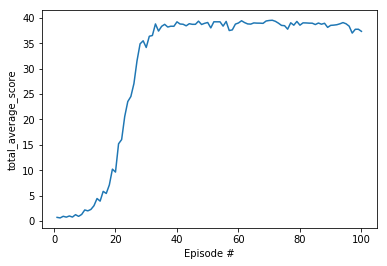

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

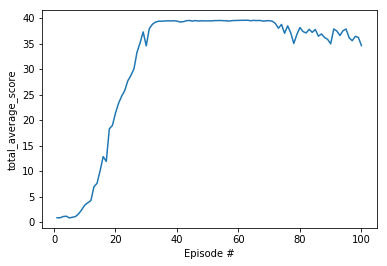

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

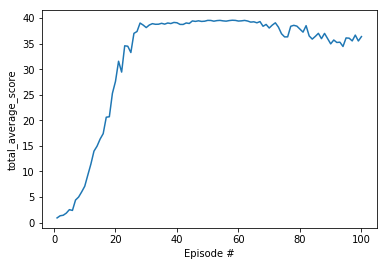

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

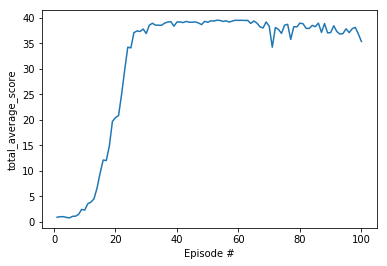

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

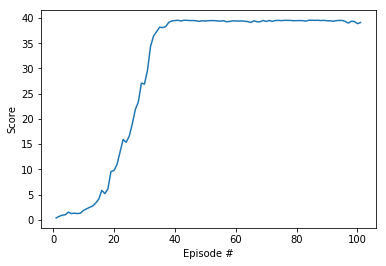

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

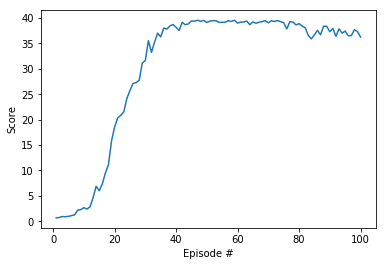

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

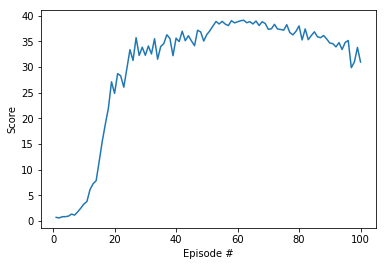

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

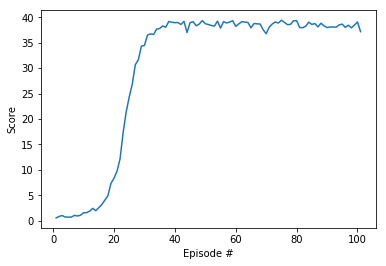

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

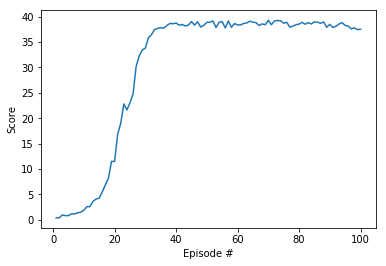

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

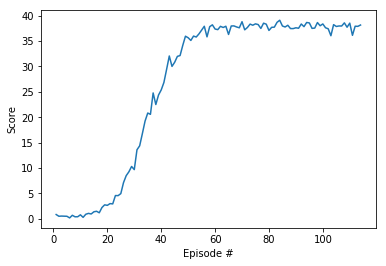

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

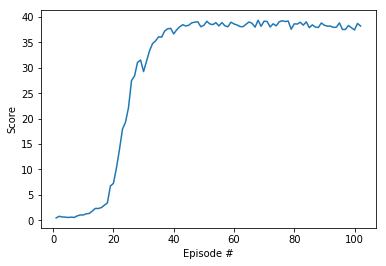

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [31]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-reacher-multiple.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-reacher-multiple.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (env)
S = env_info.vector_observations                  # get the current states (S) (for all agents)

Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for all agents)

while True:
    A = agent.act(S)                        # select actions (A) from loaded model agents
    
    env_info = env.step(A)[brain_name]           # send all actions (A) to the environment (env)
    S2 = env_info.vector_observations         # get next states (S2) (for all agents)
    rewards = env_info.rewards                         # get rewards (for all agents)
    dones = env_info.local_done                        # see if the episode is done/finished (terminal) for all agents
    
    Rs += rewards                         # update the total scores (Rs) (for all agents)
    S = S2                               # roll over current states (S) to next states (S2)
    
    if np.any(dones):                                  # exit loop if episode is done/finished for any of the agents among all of them
        break
        
print('Average of total scores: {}'.format(np.mean(Rs)))

Average of total scores: 28.70249935844913


When finished, you can close the environment.

In [32]:
env.close()